# Implementation of Word2vec

In [1]:
import sys
sys.path.insert(0, '..')

import collections
import d2l
import math
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import random
import time
import zipfile

## Pre-process the Data Set

### Load and Tokenize

In [2]:
with zipfile.ZipFile('../data/ptb.zip', 'r') as f:
    raw_text = f.read('ptb/ptb.train.txt').decode("utf-8").lower()
sentences = [line.split() for line in raw_text.split('\n')]    
'# sentences: %d' % len(sentences)

'# sentences: 42069'

### Build the Vocabulary

In [3]:
def expand(sentences):
    """Expand a list of token lists into a list of tokens"""
    return [tk for line in sentences for tk in line]

vocab = d2l.Vocab(expand(sentences), min_freq=10)
'vocab size: %d' % len(vocab)

'vocab size: 6719'

In [ ]:
class Vocab(object):
    def __init__(self, tokens, min_freq=0, use_special_tokens=False):
        counter = collections.Counter(tokens)
        token_freqs = sorted(counter.items(), key=lambda x: x[0])
        token_freqs.sort(key=lambda x: x[1], reverse=True)
        if use_special_tokens:
            self.pad, self.bos, self.eos, self.unk = (0, 1, 2, 3)
            special_tokens = ['<pad>', '<bos>', '<eos>', '<unk>']
        else:
            self.unk = 0
            special_tokens = ['<unk>']
        tokens = [token for token, freq in token_freqs
                  if freq >= min_freq and token not in special_tokens]
        self.idx_to_token = []
        self.token_to_idx = dict()
        for token in special_tokens + tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        else:
            return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        else:
            return [self.idx_to_token[index] for index in indices]

### Subsampling

Assume $f(w_i)$ is the frequency of $w_i$, the dropout probability is given as:

$$ \mathbb{P}(w_i) = \max\left(1 - \sqrt{\frac{10^{-4}}{f(w_i)}}, 0\right)$$

In [4]:
# Map low frequency words into <unk>
sentences = [[vocab.idx_to_token[vocab[tk]] for tk in line] 
             for line in sentences]
# Count the frequency for each word
tokens = expand(sentences)
counter = collections.Counter(tokens)

def discard(token):
    p = 1 - math.sqrt(1e-4 / counter[token] * len(tokens))
    return random.uniform(0, 1) < p

subsampled = [[tk for tk in line if not discard(tk)] for line in sentences]

Compare the sequence lengths before and after sampling, we can see subsampling significantly reduced the sequence length.

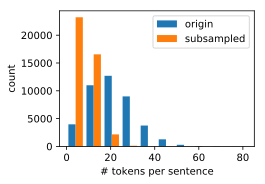

In [5]:
d2l.set_figsize()
d2l.plt.hist([[len(line) for line in sentences],
              [len(line) for line in subsampled]] )
d2l.plt.xlabel('# tokens per sentence')
d2l.plt.ylabel('count')
d2l.plt.legend(['origin', 'subsampled']);

For individual tokens, the sampling rate of the high-frequency word "the" is less than 1/20.

In [6]:
def compare_counts(token):
    return '# of "%s": before=%d, after=%d' % (token, sum(
        [line.count(token) for line in sentences]), sum(
        [line.count(token) for line in subsampled]))

print(compare_counts('the'))
print(compare_counts('join'))

# of "the": before=50770, after=2172
# of "join": before=45, after=45


### Map Tokens into Indices


In [7]:
corpus = [vocab[line] for line in subsampled]
corpus[0:3]

[[0, 0], [392, 2132, 1, 275], [5464, 3080, 1595, 95]]

## Read the Data Set

### Extract Central Target Words and Context Words

In [8]:
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        # Each sentence needs at least 2 words to form a
        # "central target word - context word" pair
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the central target word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

Create an artificial data set

In [9]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2, 3]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [3, 5]
center 5 has contexts [3, 4, 6]
center 6 has contexts [5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [8]


Set the maximum context window size to 5

In [10]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
'# center-context pairs: %d' % len(all_centers)

'# center-context pairs: 353297'

### Negative Sampling


In [11]:
class RandomGenerator(object):
    """Draw a random int in [0, n] according to n sampling weights"""
    def __init__(self, sampling_weights):
        self.population = list(range(len(sampling_weights)))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0
        
    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i-1]
    
generator = RandomGenerator([2,3,4])
[generator.draw() for _ in range(10)]

[2, 0, 2, 2, 0, 2, 0, 2, 2, 1]

In [12]:
counter = collections.Counter(expand(corpus))
sampling_weights = [counter[i]**0.75 for i in range(len(counter))]

def get_negatives(all_contexts, sampling_weights, K):
    all_negatives = []
    generator = RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, sampling_weights, 5)

### Read into Batches


In [13]:
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (nd.array(centers).reshape((-1, 1)), nd.array(contexts_negatives),
            nd.array(masks), nd.array(labels))

Construct two simple examples:

In [14]:
x_1 = (1, [2,2], [3,3,3,3])
x_2 = (1, [2,2,2], [3,3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = 
[[1.]
 [1.]]
<NDArray 2x1 @cpu(0)>
contexts_negatives = 
[[2. 2. 3. 3. 3. 3.]
 [2. 2. 2. 3. 3. 0.]]
<NDArray 2x6 @cpu(0)>
masks = 
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0.]]
<NDArray 2x6 @cpu(0)>
labels = 
[[1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]]
<NDArray 2x6 @cpu(0)>


Get data iterator

In [15]:
batch_size = 512
dataset = gdata.ArrayDataset(all_centers, all_contexts, all_negatives)
data_iter = gdata.DataLoader(dataset, batch_size, shuffle=True,
                             batchify_fn=batchify)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: (512, 1)
contexts_negatives shape: (512, 60)
masks shape: (512, 60)
labels shape: (512, 60)


## The Skip-Gram Model


### Embedding Layer


In [16]:
embed = nn.Embedding(input_dim=20, output_dim=4)
embed.initialize()
print(embed.weight)
x = nd.array([[1, 2, 3], [4, 5, 6]])
embed(x).shape

Parameter embedding0_weight (shape=(20, 4), dtype=float32)


(2, 3, 4)

### Mini-batch Multiplication

In [17]:
X = nd.ones((2, 1, 4))
Y = nd.ones((2, 4, 6))
nd.batch_dot(X, Y).shape

(2, 1, 6)

### Skip-gram Model Forward Calculation

In [18]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = nd.batch_dot(v, u.swapaxes(1, 2))
    return pred

Verify that the output shape should be (batch size, 1, `max_len`).

In [19]:
skip_gram(nd.ones((2,1)), nd.ones((2,4)), embed, embed).shape

(2, 1, 4)

## Training

### Binary Cross Entropy Loss Function

In [20]:
loss = gloss.SigmoidBinaryCrossEntropyLoss()

pred = nd.array([[.5]*4]*2)
label = nd.array([[1,0,1,0]]*2)
mask = nd.array([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask)


[0.724077  0.3620385]
<NDArray 2 @cpu(0)>

We can normalize the loss in each example due to various lengths in each example.

In [21]:
loss(pred, label, mask) / mask.sum(axis=1) * mask.shape[1]


[0.724077 0.724077]
<NDArray 2 @cpu(0)>

### Initialize Model Parameters


In [22]:
embed_size = 50
net = nn.Sequential()
net.add(nn.Embedding(input_dim=len(vocab), output_dim=embed_size),
        nn.Embedding(input_dim=len(vocab), output_dim=embed_size))

### Training



In [23]:
def train(net, lr, num_epochs):
    ctx = d2l.try_gpu()
    net.initialize(ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    for epoch in range(1, num_epochs+1):
        start, l_sum, n = time.time(), 0.0, 0
        for batch in data_iter:
            center, context_negative, mask, label = [
                data.as_in_context(ctx) for data in batch]
            with autograd.record():
                pred = skip_gram(center, context_negative, net[0], net[1])
                l = (loss(pred.reshape(label.shape), label, mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.backward()
            trainer.step(batch_size)
            l_sum += l.sum().asscalar()
            n += l.size
        print('epoch %d, loss %.2f, time %.2fs'
              % (epoch, l_sum/n, time.time() - start))

Now, we can train a skip-gram model using negative sampling.

In [24]:
train(net, 0.005, 5)

epoch 1, loss 0.47, time 20.02s
epoch 2, loss 0.41, time 20.89s
epoch 3, loss 0.38, time 22.15s
epoch 4, loss 0.37, time 30.12s
epoch 5, loss 0.36, time 30.19s


## Applying the Word Embedding Model



In [25]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data()
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability.
    cos = nd.dot(W, x) / (nd.sum(W * W, axis=1) * nd.sum(x * x) + 1e-9).sqrt()
    topk = nd.topk(cos, k=k+1, ret_typ='indices').asnumpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print('cosine sim=%.3f: %s' % (cos[i].asscalar(), (vocab.idx_to_token[i])))

get_similar_tokens('chip', 3, net[0])

cosine sim=0.672: hardware
cosine sim=0.669: intel
cosine sim=0.657: microprocessor
